# MMI726 Multimedia Standards
## Week 6: Linear Prediction Coding

- In this IPython notebook we will implement the DPCM algorithm which we discussed in the first video.
- Let us first import the modules that we will use in our implementation

In [91]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as spsig
import scipy.linalg as splin

- We will now define several functions:
    1. `uniformpcm()` a quick implementation of linear PCM with uniform step size
    2. `lpc()` calculates the prediction filter coefficients. Note that we use the `solve_toeplitz()` function from `scipy.signal` module which already implements the Levinson-Durbin recursion
    3. `dpcmencode()` is the DPCM encoder in which the residual and the prediction filter coefficients are quantised with uniform PCM. Notice that we are not checking whether the DPCM transfer function $1-A(z)$ is minimum phase (i.e. the inverse filter $[1-A(z)]^{-1}$ is stable). In a more complete implementation this should be done.
    4. `dpcmdecode()` is the DPCM decoder that receives the quantised residual and the quantised filter coefficients and reconstructs the input signal. 

In [879]:
def uniformpcm(sig, b=8, mode='round'):
    xmax = np.max(sig)
    xmin = np.min(sig)
    drange = xmax-xmin # Calculate the dynamic range
    delta = drange / (2**b-1) # Quantisation step size
    if mode=='round':
        qsig = np.round(sig / delta)
        qsig = qsig / np.max(np.abs(qsig)) * max(np.abs(xmax), np.abs(xmin))
    elif mode=='truncate':
        qsig = np.floor(sig / delta)
        qsig = qsig / np.max(np.abs(qsig)) * max(np.abs(xmax), np.abs(xmin))
    else:
        raise ValueError('Argument 3 can only be \'round\' or \'truncate\'')
        return 0
    return qsig

def lpc(sig, K):
    xc = spsig.correlate(sig, sig, "full")
    k0 = len(sig)
    r = xc[k0:k0+K]
    r0 = r[:K-1] # Note the typo on slide 20: The autocorrelation matrix should have been (K-1) by (K-1)
    r1 = r[1:]
    ak = splin.solve_toeplitz(r0, r1) # Levinson-Durbin Recursion
    return ak

def dpcmencode(sig, ak, bx, br, ba, mode='round'):
    xhat = uniformpcm(sig, bx, mode) # Quantise the input
    phat = spsig.lfilter(np.append(0, ak), 1, xhat) # Calculate the prediction
    res = sig - phat # Calculate the residual
    rhat = uniformpcm(res, br, mode) # Quantise the prediction
    ak = uniformpcm(ak, ba, mode) # Quantise the filter coefficients
    return rhat, ak

def dpcmdecode(rhat, akhat):
    xhat = spsig.lfilter(np.ones(1), np.append(np.ones(1), -akhat), rhat) # Apply the inverse prediction filter
    return xhat

- We will now define a utility function `synsig()` which will output a linear combination of a number of harmonics and noise. 
- Here, N is the total number of samples, Nsin is the number of harmonics to add, Asin are the amplitudes of each harmonic component, Anoi is the amplitude of noise, F0 is the fundamenal frequency (i.e. the frequencies of the harmonics are F0, 2F0, 3F0 etc.), and Fs is the sampling rate.

In [900]:
# Let us generate a synthetic signal comprising
def synsig(N, Nsin, Asin, Anoi, F0, Fs):
    assert Nsin * F0 < Fs / 2 # Not crucially important but let's avoid aliasing 
    n = np.arange(N)
    f0 = F0 / Fs
    noi = np.random.randn(N)
    sinsm = np.zeros(N)
    for ind in range(1, Nsin):
        sinsm += Asin[ind] * np.sin(2 * np.pi * f0 * ind * n + np.random.randn(1) * np.pi) # We also add some random phase to the argument
    return sinsm + Anoi * noi

- Let us now test `uniformpcm()`function and plot the quantisation noise for 15 and 16 bits bit depth. 

Text(0,0.5,'Quantisation noise amplitude')

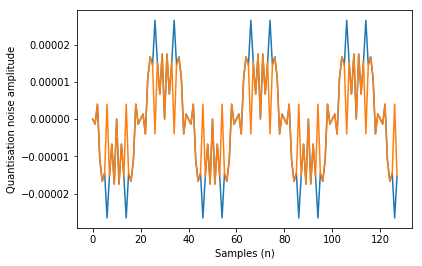

In [901]:
n = np.arange(128) # Sample indices
F = 200. # Frequency of the sine signal
Fs = 8000. # Sampling rate
sig = np.sin(2 * np.pi * F / Fs * n) # A signal containing a single sinusoid

qsig = uniformpcm(sig, 16)
plt.plot(n, qsig-sig)
qsig = uniformpcm(sig, 15)
plt.plot(n, qsig-sig)
plt.xlabel("Samples (n)")
plt.ylabel("Quantisation noise amplitude")

- Let us generate a synthetic random signal and plot it
- We will use this block of signal in LPC and LPC is typically used with a block size of 20 ms (for which speech is assumed to be stationary). Therefore, every 20 ms, the LPC prediction filter coefficients will have to be recalculated.

Text(0,0.5,'Amplitude')

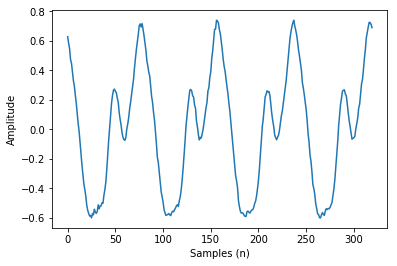

In [939]:
sig = synsig(320, 12, 0.5**np.arange(12), 0.01, 200., 16000.)

plt.plot(sig)
plt.xlabel("Samples (n)")
plt.ylabel("Amplitude")

- Let us now observe the spectrum of the signal block we generated
- We will use periodogram to analyse the spectrum of the block out of laziness! However, the constituent frequencies are clearly visible.

Text(0,0.5,'Magnitude [dB]')

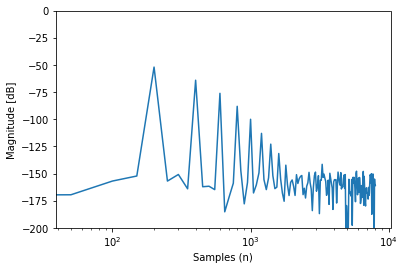

In [940]:
f, Pxx = spsig.periodogram(sig, 16000.) 
plt.semilogx(f, 20*np.log10(Pxx))
plt.ylim(-200,0)
plt.xlabel("Samples (n)")
plt.ylabel("Magnitude [dB]")

- Let us now check out the autocorrelation sequence that we will use in the calculation of the LPC coefficients.
- Notice that the mipoint sample represents zero lag and is maximum as expected.

Text(0,0.5,'Autocorrelation amplitude')

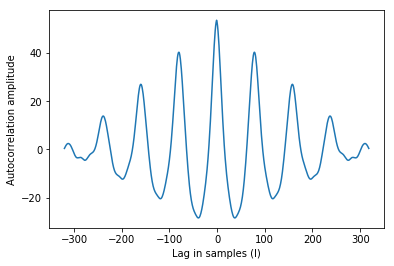

In [941]:
xc = spsig.correlate(sig, sig, "full", method='direct')

plt.plot(np.arange(-320,319), xc)
plt.xlabel("Lag in samples (l)")
plt.ylabel("Autocorrelation amplitude")

- We will now calculate the LPC coefficients for our block and use it in DPCM to encode our signal block. We pick the model order as $K=5$ as it seems to provide good results. A practical application would need more careful consideration of the model order.
- In a more realistic scenario, the signal will be made up of multiple blocks like these so DPCM encoder would work in a loop.
- We will internally quantise the input with 16-bits, the resulting residual with 10-bits, and the filter coefficients with 16-bits. Remember that in real life the results would be packaged into a bitstream and transferred over the network. We are not interested in that right now!

Text(0,0.5,'Amplitude')

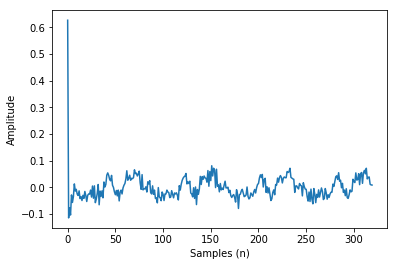

In [942]:
ak = lpc(sig, 8)
rhat, akhat = dpcmencode(sig, ak, 16, 10, 16)

plt.plot(np.arange(320), rhat)
plt.xlabel("Samples (n)")
plt.ylabel("Amplitude")

- Let us now calculate the coding gain as we discussed in the lecture video 

In [943]:
codinggain = np.var(sig) / np.var(rhat)
print("The coding gain is ", 10*np.log10(codinggain), "in dB")

('The coding gain is ', 18.478034771942426, 'in dB')


- Assume now that we transferred this signal block and the LPC coefficients over the network and the decoder received them to use for reconstructing the signal block. Therefore, we have to use the quantised filter coefficients.
- We will then plot our signal and the reconstucted signal, as well as the error and see that they match.

Text(0,0.5,'Amplitude')

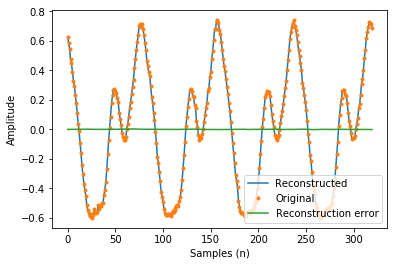

In [955]:
xhat = dpcmdecode(rhat, akhat)

n = np.arange(320)
plt.plot(n, xhat, label="Reconstructed")
plt.gca().legend(loc=4)
plt.plot(n, sig, '.', label="Original")
plt.gca().legend(loc=4)
plt.plot(n, xhat-sig, label="Reconstruction error")
plt.gca().legend(loc=4)
plt.xlabel("Samples (n)")
plt.ylabel("Amplitude")

#### © 2020, Huseyin Hacihabiboglu, (hhuseyin@metu.edu.tr), METU Graduate School of Informatics